In [80]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
import numpy as np
import scipy.stats as stats
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.utils import check_array
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
# Definitions
pd.set_option('display.float_format', lambda x: '%.3f' % x)
%matplotlib inline

In [2]:
train_url = 'https://raw.githubusercontent.com/ellenne/rawdata/master/train.csv'
test_url = 'https://raw.githubusercontent.com/ellenne/rawdata/master/test.csv'

In [3]:
df_train = pd.read_csv(train_url)
df_test = pd.read_csv(test_url)

Here we separate our variables into numeric and categorical. We also take out the `Id` and `SalePrice` will be set as output variable

In [4]:
all_vars = list(df_train)
output_var = 'SalePrice'
num_vars = list(df_train._get_numeric_data())
cat_vars = list(set(all_vars) - set(num_vars))
num_vars = list(set(num_vars) - set(['SalePrice', 'Id']))
(output_var, num_vars, cat_vars)

('SalePrice',
 ['BsmtFullBath',
  'YearRemodAdd',
  'BedroomAbvGr',
  '3SsnPorch',
  'MSSubClass',
  'LotArea',
  'YearBuilt',
  'BsmtFinSF2',
  'TotalBsmtSF',
  'OverallCond',
  'MasVnrArea',
  'LowQualFinSF',
  'GarageArea',
  'KitchenAbvGr',
  'ScreenPorch',
  'WoodDeckSF',
  'BsmtHalfBath',
  'OpenPorchSF',
  'BsmtFinSF1',
  '2ndFlrSF',
  'MoSold',
  'FullBath',
  'TotRmsAbvGrd',
  'HalfBath',
  'BsmtUnfSF',
  'GrLivArea',
  'GarageYrBlt',
  'MiscVal',
  'YrSold',
  'LotFrontage',
  'PoolArea',
  'OverallQual',
  'EnclosedPorch',
  'GarageCars',
  'Fireplaces',
  '1stFlrSF'],
 ['Exterior1st',
  'RoofStyle',
  'Heating',
  'Neighborhood',
  'BsmtCond',
  'MasVnrType',
  'HeatingQC',
  'PavedDrive',
  'SaleType',
  'LandContour',
  'LotShape',
  'Exterior2nd',
  'Alley',
  'MSZoning',
  'FireplaceQu',
  'Utilities',
  'MiscFeature',
  'PoolQC',
  'LandSlope',
  'GarageType',
  'BsmtFinType1',
  'RoofMatl',
  'HouseStyle',
  'Fence',
  'CentralAir',
  'BsmtQual',
  'Condition2',
  'St

In [5]:
## for the categorical variables if there is a missing value the category MISSING is created and filled
for c in cat_vars:
    df_train[c] = df_train[c].astype('category')
    if df_train[c].isnull().any():        
        df_train[c] = df_train[c].cat.add_categories(['MISSING'])
        df_train[c] = df_train[c].fillna('MISSING')

In [6]:
## same for test set
for c in cat_vars:
    df_test[c] = df_test[c].astype('category')
    if df_test[c].isnull().any():        
        df_test[c] = df_test[c].cat.add_categories(['MISSING'])
        df_test[c] = df_test[c].fillna('MISSING')

In [7]:
# function to encode the categorical variables
def encode(frame, feature):
    list_1 = pd.DataFrame()
    # level for each variable
    list_1['level'] = frame[feature].unique()
    # since we will make use of dictionaries, having the index will make the index the key (!!)
    list_1.index = list_1.level
    # connected mean of sales price for the current level
    list_1['spmean'] = frame[[feature, output_var]].groupby(feature).mean()[output_var]
    # then we have to order
    list_1 = list_1.sort_values('spmean')
    # then we can create the value that we want to assign - from 1 to rows list_1+1 (note we cannot use len because)
    # list_1 is a dataframe and not a list
    values = []
    j = 1
    for i in range(0, len(list_1)):
        if list_1['level'][i].upper() in ['MISSING', 'NONE', 'NA', 'N']:
            values.append(0)
        else:
            values.append(j)
            j += 1
            
    list_1['value'] = values
    # now let's make use of dictionaries that are so wonderful for cases like these
    list_1 = list_1['value'].to_dict()    
    for cat, o in list_1.items():
        frame.loc[frame[feature] == cat, feature+'_E'] = o

cat_vars_Enc = []
for q in cat_vars:
    encode(df_train, q)    
    cat_vars_Enc.append(q+"_E")

cat_vars_Enc

['Exterior1st_E',
 'RoofStyle_E',
 'Heating_E',
 'Neighborhood_E',
 'BsmtCond_E',
 'MasVnrType_E',
 'HeatingQC_E',
 'PavedDrive_E',
 'SaleType_E',
 'LandContour_E',
 'LotShape_E',
 'Exterior2nd_E',
 'Alley_E',
 'MSZoning_E',
 'FireplaceQu_E',
 'Utilities_E',
 'MiscFeature_E',
 'PoolQC_E',
 'LandSlope_E',
 'GarageType_E',
 'BsmtFinType1_E',
 'RoofMatl_E',
 'HouseStyle_E',
 'Fence_E',
 'CentralAir_E',
 'BsmtQual_E',
 'Condition2_E',
 'Street_E',
 'BldgType_E',
 'Condition1_E',
 'GarageFinish_E',
 'ExterQual_E',
 'BsmtFinType2_E',
 'BsmtExposure_E',
 'LotConfig_E',
 'KitchenQual_E',
 'ExterCond_E',
 'GarageQual_E',
 'Electrical_E',
 'Foundation_E',
 'SaleCondition_E',
 'GarageCond_E',
 'Functional_E']

In [8]:
# this method copies the encode of encodedFrame in frame. The underlying hypothesis is that the encoded frame contains
# the raw variable and the encoded one that has the same name + '_E', so the method builds the dictionary level, value
# and apply it to the frame. It fails if the frame contains values not present in the encodedFrame
def copyEncode(encodedFrame, frame, feature):    
    list_1 = pd.DataFrame()
    # level for each variable
    list_1['level'] = encodedFrame[feature].unique()    
    levels = encodedFrame[feature].unique()    
    # build the values
    values = []
    for lev in levels:
        values.append(min(encodedFrame[feature + '_E'].loc[encodedFrame[feature] == lev]))
    list_1['value'] = values
    
    # now let's make use of dictionaries that are so wonderful for cases like these
    list_1d = {}
    for val in values:
        list_1d[list_1['level'][values.index(val)]] = val
    # a missing element can be present in the test set but not in the training set
    list_1d['MISSING'] = 0
    list_1 = list_1d        
    for cat, o in list_1.items():
        frame.loc[frame[feature] == cat, feature+'_E'] = o
        
for q in cat_vars:
    copyEncode(df_train, df_test, q)    
    print(q+"_E")

Exterior1st_E
RoofStyle_E
Heating_E
Neighborhood_E
BsmtCond_E
MasVnrType_E
HeatingQC_E
PavedDrive_E
SaleType_E
LandContour_E
LotShape_E
Exterior2nd_E
Alley_E
MSZoning_E
FireplaceQu_E
Utilities_E
MiscFeature_E
PoolQC_E
LandSlope_E
GarageType_E
BsmtFinType1_E
RoofMatl_E
HouseStyle_E
Fence_E
CentralAir_E
BsmtQual_E
Condition2_E
Street_E
BldgType_E
Condition1_E
GarageFinish_E
ExterQual_E
BsmtFinType2_E
BsmtExposure_E
LotConfig_E
KitchenQual_E
ExterCond_E
GarageQual_E
Electrical_E
Foundation_E
SaleCondition_E
GarageCond_E
Functional_E


In [9]:
df_train.shape, df_train.shape

((1460, 124), (1460, 124))

In [10]:
len(cat_vars) + len(cat_vars_Enc) + len(num_vars)

122

Let's define our KPI - Root Mean Squared Logaritmic Error. In the rank tihs is used as KPI to evaluate the model.  <br/>


This function will be used to evaluate the goodness of the model.

In [11]:
## RMSLE - Root Mean Squared Logaritmic Error
## https://www.kaggle.com/marknagelberg/rmsle-function
## This is the parameter used to rank models
def rmsle(y_pred, y_test) : 
    assert len(y_test) == len(y_pred)
    return np.sqrt(np.mean((np.log(1+y_pred) - np.log(1+y_test))**2))

Now we will begin our feature engineering. We will add new features, simplify some and transform others so that we will have a wider range of features between which we can choose those that best fit our model.

In [12]:
## variable simplification - I put S after the variable name

df_train["SimplOverallQual_S"] = df_train['OverallQual'].replace(
    {1 : 1, 2 : 1, 3 : 1,        # bad
     4 : 2, 5 : 2, 6 : 2,        # average
     7 : 3, 8 : 3, 9 : 3, 10 : 3 # good
    })

df_train["SimplOverallCond_S"] = df_train['OverallCond'].replace(
    {1 : 1, 2 : 1, 3 : 1, # bad
     4 : 2, 5 : 2, 6 : 2, # average
     7 : 3, 8 : 3, 9 : 3, 10 : 3 # good
    })

df_train["SimplPoolQC_S"] = df_train['PoolQC_E'].replace(
    {1 : 1, 2 : 1, # average
     3 : 2, 4 : 2  # good
    })

df_train["SimplGarageCond_S"] = df_train['GarageCond_E'].replace(
    {1 : 1, # bad
     2 : 1, 3 : 1, # average
     4 : 2, 5 : 2 # good
     })

df_train["SimplGarageQual_S"] = df_train['GarageQual_E'].replace(
    {1 : 1, # bad
     2 : 1, 3 : 1, # average
     4 : 2, 5 : 2 # good
    })

df_train["SimplFireplaceQu_S"] = df_train['FireplaceQu_E'].replace(
    {1 : 1, # bad
     2 : 1, 3 : 1, # average
     4 : 2, 5 : 2 # good
    })

df_train["SimplFunctional_S"] = df_train['Functional_E'].replace(
    {1 : 1, 2 : 1, # bad
     3 : 2, 4 : 2, # major
     5 : 3, 6 : 3, 7 : 3, # minor
     8 : 4 # typical
    })

df_train["SimplKitchenQual_S"] = df_train['KitchenQual_E'].replace(
    {1 : 1, # bad
     2 : 1, 3 : 1, # average
     4 : 2, 5 : 2 # good
    })

df_train["SimplHeatingQC_S"] = df_train['HeatingQC_E'].replace(
    {1 : 1, # bad
     2 : 1, 3 : 1, # average
     4 : 2, 5 : 2 # good
    })

df_train["SimplBsmtFinType1_S"] = df_train['BsmtFinType1_E'].replace(
    {1 : 1, # unfinished
     2 : 1, 3 : 1, # rec room
     4 : 2, 5 : 2, 6 : 2 # living quarters
    })

df_train["SimplBsmtFinType2_S"] = df_train['BsmtFinType2_E'].replace(
    {1 : 1, # unfinished
     2 : 1, 3 : 1, # rec room
     4 : 2, 5 : 2, 6 : 2 # living quarters
    })

df_train["SimplBsmtCond_S"] = df_train['BsmtCond_E'].replace(
    {1 : 1, # bad
     2 : 1, 3 : 1, # average
     4 : 2, 5 : 2 # good
    })

df_train["SimplBsmtQual_S"] = df_train['BsmtQual_E'].replace(
    {1 : 1, # bad
     2 : 1, 3 : 1, # average
     4 : 2, 5 : 2 # good
    })

df_train["SimplExterCond_S"] = df_train['ExterCond_E'].replace(
    {1 : 1, # bad
     2 : 1, 3 : 1, # average
     4 : 2, 5 : 2 # good
    })

df_train["SimplExterQual_S"] = df_train['ExterQual_E'].replace(
    {1 : 1, # bad
     2 : 1, 3 : 1, # average
     4 : 2, 5 : 2 # good
    })

# House completed before sale or not
df_train["BoughtOffPlan_S"] = df_train['SaleCondition'].replace(
    {"Abnorml" : 0, "Alloca" : 0, "AdjLand" : 0,
     "Family" : 0, "Normal" : 0, "Partial" : 1})

# Has masonry veneer or not
df_train["HasMasVnr_S"] = df_train['MasVnrType'].replace(
    {"BrkCmn" : 1, "BrkFace" : 1, "CBlock" : 1, "Stone" : 1, "None" : 0, "MISSING": 0})

In [13]:
## variable simplification in the training

df_test["SimplOverallQual_S"] = df_test['OverallQual'].replace(
    {1 : 1, 2 : 1, 3 : 1,        # bad
     4 : 2, 5 : 2, 6 : 2,        # average
     7 : 3, 8 : 3, 9 : 3, 10 : 3 # good
    })

df_test["SimplOverallCond_S"] = df_test['OverallCond'].replace(
    {1 : 1, 2 : 1, 3 : 1, # bad
     4 : 2, 5 : 2, 6 : 2, # average
     7 : 3, 8 : 3, 9 : 3, 10 : 3 # good
    })

df_test["SimplPoolQC_S"] = df_test['PoolQC_E'].replace(
    {1 : 1, 2 : 1, # average
     3 : 2, 4 : 2  # good
    })

df_test["SimplGarageCond_S"] = df_test['GarageCond_E'].replace(
    {1 : 1, # bad
     2 : 1, 3 : 1, # average
     4 : 2, 5 : 2 # good
     })

df_test["SimplGarageQual_S"] = df_test['GarageQual_E'].replace(
    {1 : 1, # bad
     2 : 1, 3 : 1, # average
     4 : 2, 5 : 2 # good
    })

df_test["SimplFireplaceQu_S"] = df_test['FireplaceQu_E'].replace(
    {1 : 1, # bad
     2 : 1, 3 : 1, # average
     4 : 2, 5 : 2 # good
    })

df_test["SimplFunctional_S"] = df_test['Functional_E'].replace(
    {1 : 1, 2 : 1, # bad
     3 : 2, 4 : 2, # major
     5 : 3, 6 : 3, 7 : 3, # minor
     8 : 4 # typical
    })

df_test["SimplKitchenQual_S"] = df_test['KitchenQual_E'].replace(
    {1 : 1, # bad
     2 : 1, 3 : 1, # average
     4 : 2, 5 : 2 # good
    })

df_test["SimplHeatingQC_S"] = df_test['HeatingQC_E'].replace(
    {1 : 1, # bad
     2 : 1, 3 : 1, # average
     4 : 2, 5 : 2 # good
    })

df_test["SimplBsmtFinType1_S"] = df_test['BsmtFinType1_E'].replace(
    {1 : 1, # unfinished
     2 : 1, 3 : 1, # rec room
     4 : 2, 5 : 2, 6 : 2 # living quarters
    })

df_test["SimplBsmtFinType2_S"] = df_test['BsmtFinType2_E'].replace(
    {1 : 1, # unfinished
     2 : 1, 3 : 1, # rec room
     4 : 2, 5 : 2, 6 : 2 # living quarters
    })

df_test["SimplBsmtCond_S"] = df_test['BsmtCond_E'].replace(
    {1 : 1, # bad
     2 : 1, 3 : 1, # average
     4 : 2, 5 : 2 # good
    })

df_test["SimplBsmtQual_S"] = df_test['BsmtQual_E'].replace(
    {1 : 1, # bad
     2 : 1, 3 : 1, # average
     4 : 2, 5 : 2 # good
    })

df_test["SimplExterCond_S"] = df_test['ExterCond_E'].replace(
    {1 : 1, # bad
     2 : 1, 3 : 1, # average
     4 : 2, 5 : 2 # good
    })

df_test["SimplExterQual_S"] = df_test['ExterQual_E'].replace(
    {1 : 1, # bad
     2 : 1, 3 : 1, # average
     4 : 2, 5 : 2 # good
    })

# House completed before sale or not
df_test["BoughtOffPlan_S"] = df_test['SaleCondition'].replace(
    {"Abnorml" : 0, "Alloca" : 0, "AdjLand" : 0,
     "Family" : 0, "Normal" : 0, "Partial" : 1})

# Has masonry veneer or not
df_test["HasMasVnr_S"] = df_test['MasVnrType'].replace(
    {"BrkCmn" : 1, "BrkFace" : 1, "CBlock" : 1, "Stone" : 1, "None" : 0, "MISSING": 0})

In [14]:
cat_vars_S = ['SimplOverallQual_S', 'SimplOverallCond_S', 'SimplPoolQC_S', 
              'SimplGarageCond_S', 'SimplGarageQual_S', 'SimplFireplaceQu_S', 
              'SimplFunctional_S', 'SimplKitchenQual_S', 'SimplHeatingQC_S', 
              'SimplBsmtFinType1_S', 'SimplBsmtFinType2_S', 'SimplBsmtCond_S', 
              'SimplBsmtQual_S', 'SimplExterCond_S', 'SimplExterQual_S', 
              'BoughtOffPlan_S', 'HasMasVnr_S']

In [15]:
df_train["OverallGrade_D"] = df_train["OverallQual"].astype(np.float64) * \
                              df_train["OverallCond"].astype(np.float64)

# Overall quality of the garage
df_train["GarageGrade_D"] = df_train["GarageQual_E"].astype(np.float64) * \
                            df_train["GarageCond_E"].astype(np.float64)

# Overall quality of the exterior
df_train["ExterGrade_D"] = df_train["ExterQual_E"].astype(np.float64) * \
                          df_train["ExterCond_E"].astype(np.float64)

# Overall kitchen score
df_train["KitchenScore_D"] = df_train["KitchenAbvGr"].astype(np.float64) * \
                            df_train["KitchenQual_E"].astype(np.float64)

# Overall fireplace score
df_train["FireplaceScore_D"] = df_train["Fireplaces"].astype(np.float64) * \
                              df_train["FireplaceQu_E"].astype(np.float64)

# Overall garage score
df_train["GarageScore_D"] = df_train["GarageArea"].astype(np.float64) * \
                            df_train["GarageQual_E"].astype(np.float64)

# Overall pool score
df_train["PoolScore_D"] = df_train["PoolArea"].astype(np.float64) * \
                          df_train["PoolQC_E"].astype(np.float64)

# Simplified overall quality of the house
df_train["SimplOverallGrade_D"] = df_train["SimplOverallQual_S"].astype(np.float64) * \
                               df_train["SimplOverallCond_S"].astype(np.float64)

# Simplified overall pool score
df_train["SimplPoolScore_D"] = df_train["PoolArea"].astype(np.float64) * \
                                df_train["SimplPoolQC_S"].astype(np.float64)

# Simplified overall garage score
df_train["SimplGarageScore_D"] = df_train["GarageArea"].astype(np.float64) * \
                                df_train["SimplGarageQual_S"].astype(np.float64)

# Simplified overall fireplace score
df_train["SimplFireplaceScore_D"] = df_train["Fireplaces"].astype(np.float64) *\
                              df_train["SimplFireplaceQu_S"].astype(np.float64)

# Simplified overall kitchen score
df_train["SimplKitchenScore_D"] = df_train["KitchenAbvGr"].astype(np.float64) * \
                              df_train["SimplKitchenQual_S"].astype(np.float64)

# Total number of bathrooms
df_train["TotalBath_D"] = df_train["BsmtFullBath"] + \
                        (0.5 * df_train["BsmtHalfBath"]) + df_train["FullBath"] +\
                        (0.5 * df_train["HalfBath"])

# Total SF for house (incl. basement)
df_train["AllSF_D"] = df_train["GrLivArea"] + df_train["TotalBsmtSF"]

# Total SF for 1st + 2nd floors
df_train["AllFlrsSF_D"] = df_train["1stFlrSF"] + df_train["2ndFlrSF"]

# Total SF for porch
df_train["AllPorchSF_D"] = df_train["OpenPorchSF"] + df_train["EnclosedPorch"] + \
                          df_train["3SsnPorch"] + df_train["ScreenPorch"]

# Simplified overall quality of the exterior
df_train["SimplExterGrade_D"] = df_train["SimplExterQual_S"].astype(np.float64) * \
                            df_train["SimplExterCond_S"].astype(np.float64)

In [16]:
# variable transformation in test set

# Overall quality of the house
df_test["OverallGrade_D"] = df_test["OverallQual"].astype(np.float64) * \
                            df_test["OverallCond"].astype(np.float64)

# Overall quality of the garage
df_test["GarageGrade_D"] = df_test["GarageQual_E"].astype(np.float64) * \
                            df_test["GarageCond_E"].astype(np.float64)

# Overall quality of the exterior
df_test["ExterGrade_D"] = df_test["ExterQual_E"].astype(np.float64) * \
                          df_test["ExterCond_E"].astype(np.float64)

# Overall kitchen score
df_test["KitchenScore_D"] = df_test["KitchenAbvGr"].astype(np.float64) * \
                            df_test["KitchenQual_E"].astype(np.float64)

# Overall fireplace score
df_test["FireplaceScore_D"] = df_test["Fireplaces"].astype(np.float64) * \
                              df_test["FireplaceQu_E"].astype(np.float64)

# Overall garage score
df_test["GarageScore_D"] = df_test["GarageArea"].astype(np.float64) * \
                            df_test["GarageQual_E"].astype(np.float64)

# Overall pool score
df_test["PoolScore_D"] = df_test["PoolArea"].astype(np.float64) * \
                          df_test["PoolQC_E"].astype(np.float64)

# Simplified overall quality of the house
df_test["SimplOverallGrade_D"] = df_test["SimplOverallQual_S"].astype(np.float64) * \
                              df_test["SimplOverallCond_S"].astype(np.float64)

# Simplified overall pool score
df_test["SimplPoolScore_D"] = df_test["PoolArea"].astype(np.float64) * \
                              df_test["SimplPoolQC_S"].astype(np.float64)

# Simplified overall garage score
df_test["SimplGarageScore_D"] = df_test["GarageArea"].astype(np.float64) * \
                                df_test["SimplGarageQual_S"].astype(np.float64)

# Simplified overall fireplace score
df_test["SimplFireplaceScore_D"] = df_test["Fireplaces"].astype(np.float64) * \
                                df_test["SimplFireplaceQu_S"].astype(np.float64)

# Simplified overall kitchen score
df_test["SimplKitchenScore_D"] = df_test["KitchenAbvGr"].astype(np.float64) * \
                                df_test["SimplKitchenQual_S"].astype(np.float64)

# Total number of bathrooms
df_test["TotalBath_D"] = df_test["BsmtFullBath"] + \
                        (0.5 * df_test["BsmtHalfBath"]) + \
                          df_test["FullBath"] + \
                        (0.5 * df_test["HalfBath"])

# Total SF for house (incl. basement)
df_test["AllSF_D"] = df_test["GrLivArea"] + df_test["TotalBsmtSF"]

# Total SF for 1st + 2nd floors
df_test["AllFlrsSF_D"] = df_test["1stFlrSF"] + df_test["2ndFlrSF"]

# Total SF for porch
df_test["AllPorchSF_D"] = df_test["OpenPorchSF"] + df_test["EnclosedPorch"] + \
                          df_test["3SsnPorch"] + df_test["ScreenPorch"]

# Simplified overall quality of the exterior
df_test["SimplExterGrade_D"] = df_test["SimplExterQual_S"].astype(np.float64) * \
                                df_test["SimplExterCond_S"].astype(np.float64)

In [17]:
cat_vars_D = ['OverallGrade_D', 'GarageGrade_D', 'ExterGrade_D', 'KitchenScore_D', 
              'FireplaceScore_D', 'GarageScore_D', 'PoolScore_D', 'SimplOverallGrade_D', 
              'SimplPoolScore_D', 'SimplGarageScore_D', 'SimplFireplaceScore_D', 
              'SimplKitchenScore_D', 'TotalBath_D', 'AllSF_D', 'AllFlrsSF_D', 
              'AllPorchSF_D', 'SimplExterGrade_D']

In [18]:
# Create new features
# 3* Polynomials on the top 10 existing features
df_train["OverallQual_TL2"] = np.log10(df_train["OverallQual"] ** 2 + 1)
df_train["OverallQual_TL3"] = np.log10(df_train["OverallQual"] ** 3 + 1)
df_train["OverallQual_TSQ"] = np.sqrt(df_train["OverallQual"])
df_train["OverallQual_TLOG"] = np.log10(df_train["OverallQual"] + 1)

df_train["AllSF_TL2"] = np.log10(df_train["AllSF_D"] ** 2 + 1)
df_train["AllSF_TL3"] = np.log10(df_train["AllSF_D"] ** 3 + 1)
df_train["AllSF_TSQ"] = np.sqrt(df_train["AllSF_D"])
df_train["AllSF_TLOG"] = np.log10(df_train["AllSF_D"] + 1)

df_train["AllFlrsSF_TL2"] = np.log10(df_train["AllFlrsSF_D"] ** 2 + 1)
df_train["AllFlrsSF_TL3"] = np.log10(df_train["AllFlrsSF_D"] ** 3 + 1)
df_train["AllFlrsSF_TSQ"] = np.sqrt(df_train["AllFlrsSF_D"])
df_train["AllFlrsSF_TLOG"] = np.log10(df_train["AllFlrsSF_D"] + 1)

df_train["GrLivArea_TL2"] = np.log10(df_train["GrLivArea"] ** 2 + 1)
df_train["GrLivArea_TL3"] = np.log10(df_train["GrLivArea"] ** 3 + 1)
df_train["GrLivArea_TSQ"] = np.sqrt(df_train["GrLivArea"])
df_train["GrLivArea_TLOG"] = np.log10(df_train["GrLivArea"] + 1)

df_train["SimplOverallQual_TL2"] = np.log10(df_train["SimplOverallQual_S"] ** 2 + 1)
df_train["SimplOverallQual_TL3"] = np.log10(df_train["SimplOverallQual_S"] ** 3 + 1)
df_train["SimplOverallQual_TSQ"] = np.sqrt(df_train["SimplOverallQual_S"])
df_train["SimplOverallQual_TLOG"] = np.log10(df_train["SimplOverallQual_S"] + 1)

df_train["ExterQual_TL2"] = np.log10(df_train["ExterQual_E"] ** 2 + 1)
df_train["ExterQual_TL3"] = np.log10(df_train["ExterQual_E"] ** 3 + 1)
df_train["ExterQual_TSQ"] = np.sqrt(df_train["ExterQual_E"])
df_train["ExterQual_TLOG"] = np.log10(df_train["ExterQual_E"] + 1) 

df_train["GarageCars_TL2"] = np.log10(df_train["GarageCars"] ** 2 + 1)
df_train["GarageCars_TL3"] = np.log10(df_train["GarageCars"] ** 3 + 1)
df_train["GarageCars_TSQ"] = np.sqrt(df_train["GarageCars"])
df_train["GarageCars_TLOG"] = np.log10(df_train["GarageCars"] + 1)

df_train["TotalBath_TL2"] = np.log10(df_train["TotalBath_D"] ** 2 + 1)
df_train["TotalBath_TL3"] = np.log10(df_train["TotalBath_D"] ** 3 + 1)
df_train["TotalBath_TSQ"] = np.sqrt(df_train["TotalBath_D"])
df_train["TotalBath_TLOG"] = np.log10(df_train["TotalBath_D"] + 1)

df_train["KitchenQual_TL2"] = np.log10(df_train["KitchenQual_E"] ** 2 + 1)
df_train["KitchenQual_TL3"] = np.log10(df_train["KitchenQual_E"] ** 3 + 1)
df_train["KitchenQual_TSQ"] = np.sqrt(df_train["KitchenQual_E"])
df_train["KitchenQual_TLOG"] = np.log10(df_train["KitchenQual_E"] + 1)

df_train["GarageScore_TL2"] = np.log10(df_train["GarageScore_D"] ** 2 + 1)
df_train["GarageScore_TL3"] = np.log10(df_train["GarageScore_D"] ** 3 + 1)
df_train["GarageScore_TSQ"] = np.sqrt(df_train["GarageScore_D"])
df_train["GarageScore_TLOG"] = np.log10(df_train["GarageScore_D"] + 1)

In [19]:
# transformation for test set
df_test["OverallQual_TL2"] = np.log10(df_test["OverallQual"] ** 2 + 1)
df_test["OverallQual_TL3"] = np.log10(df_test["OverallQual"] ** 3 + 1)
df_test["OverallQual_TSQ"] = np.sqrt(df_test["OverallQual"])
df_test["OverallQual_TLOG"] = np.log10(df_test["OverallQual"] + 1)

df_test["AllSF_TL2"] = np.log10(df_test["AllSF_D"] ** 2 + 1)
df_test["AllSF_TL3"] = np.log10(df_test["AllSF_D"] ** 3 + 1)
df_test["AllSF_TSQ"] = np.sqrt(df_test["AllSF_D"])
df_test["AllSF_TLOG"] = np.log10(df_test["AllSF_D"] + 1)

df_test["AllFlrsSF_TL2"] = np.log10(df_test["AllFlrsSF_D"] ** 2 + 1)
df_test["AllFlrsSF_TL3"] = np.log10(df_test["AllFlrsSF_D"] ** 3 + 1)
df_test["AllFlrsSF_TSQ"] = np.sqrt(df_test["AllFlrsSF_D"])
df_test["AllFlrsSF_TLOG"] = np.log10(df_test["AllFlrsSF_D"] + 1)

df_test["GrLivArea_TL2"] = np.log10(df_test["GrLivArea"] ** 2 + 1)
df_test["GrLivArea_TL3"] = np.log10(df_test["GrLivArea"] ** 3 + 1)
df_test["GrLivArea_TSQ"] = np.sqrt(df_test["GrLivArea"])
df_test["GrLivArea_TLOG"] = np.log10(df_test["GrLivArea"] + 1)

df_test["SimplOverallQual_TL2"] = np.log10(df_test["SimplOverallQual_S"] ** 2 + 1)
df_test["SimplOverallQual_TL3"] = np.log10(df_test["SimplOverallQual_S"] ** 3 + 1)
df_test["SimplOverallQual_TSQ"] = np.sqrt(df_test["SimplOverallQual_S"])
df_test["SimplOverallQual_TLOG"] = np.log10(df_test["SimplOverallQual_S"] + 1)

df_test["ExterQual_TL2"] = np.log10(df_test["ExterQual_E"] ** 2 + 1)
df_test["ExterQual_TL3"] = np.log10(df_test["ExterQual_E"] ** 3 + 1)
df_test["ExterQual_TSQ"] = np.sqrt(df_test["ExterQual_E"])
df_test["ExterQual_TLOG"] = np.log10(df_test["ExterQual_E"] + 1) 

df_test["GarageCars_TL2"] = np.log10(df_test["GarageCars"] ** 2 + 1)
df_test["GarageCars_TL3"] = np.log10(df_test["GarageCars"] ** 3 + 1)
df_test["GarageCars_TSQ"] = np.sqrt(df_test["GarageCars"])
df_test["GarageCars_TLOG"] = np.log10(df_test["GarageCars"] + 1)

df_test["TotalBath_TL2"] = np.log10(df_test["TotalBath_D"] ** 2 + 1)
df_test["TotalBath_TL3"] = np.log10(df_test["TotalBath_D"] ** 3 + 1)
df_test["TotalBath_TSQ"] = np.sqrt(df_test["TotalBath_D"])
df_test["TotalBath_TLOG"] = np.log10(df_test["TotalBath_D"] + 1)

df_test["KitchenQual_TL2"] = np.log10(df_test["KitchenQual_E"] ** 2 + 1)
df_test["KitchenQual_TL3"] = np.log10(df_test["KitchenQual_E"] ** 3 + 1)
df_test["KitchenQual_TSQ"] = np.sqrt(df_test["KitchenQual_E"])
df_test["KitchenQual_TLOG"] = np.log10(df_test["KitchenQual_E"] + 1)

df_test["GarageScore_TL2"] = np.log10(df_test["GarageScore_D"] ** 2 + 1)
df_test["GarageScore_TL3"] = np.log10(df_test["GarageScore_D"] ** 3 + 1)
df_test["GarageScore_TSQ"] = np.sqrt(df_test["GarageScore_D"])
df_test["GarageScore_TLOG"] = np.log10(df_test["GarageScore_D"] + 1)

In [20]:
cat_vars_T = ['OverallQual_TL2', 'OverallQual_TL3', 'OverallQual_TSQ', 'OverallQual_TLOG',
              'AllSF_TL2', 'AllSF_TL3', 'AllSF_TSQ', 'AllSF_TLOG', 'AllFlrsSF_TL2', 
              'AllFlrsSF_TL3', 'AllFlrsSF_TSQ', 'AllFlrsSF_TLOG', 'GrLivArea_TL2', 
              'GrLivArea_TL3', 'GrLivArea_TSQ', 'GrLivArea_TLOG', 'SimplOverallQual_TL2',
              'SimplOverallQual_TL3', 'SimplOverallQual_TSQ', 'SimplOverallQual_TLOG', 
              'ExterQual_TL2', 'ExterQual_TL3', 'ExterQual_TSQ', 'ExterQual_TLOG', 
              'GarageCars_TL2', 'GarageCars_TL3', 'GarageCars_TSQ', 'GarageCars_TLOG', 
              'TotalBath_TL2', 'TotalBath_TL3', 'TotalBath_TSQ', 'TotalBath_TLOG', 
              'KitchenQual_TL2', 'KitchenQual_TL3', 'KitchenQual_TSQ', 'KitchenQual_TLOG',
              'GarageScore_TL2', 'GarageScore_TL3', 'GarageScore_TSQ', 'GarageScore_TLOG']

In [21]:
len(num_vars) + len(cat_vars_Enc) + len(cat_vars_D) + len(cat_vars_S) + len(cat_vars_T)

153

In [22]:
all_vars = num_vars + cat_vars_Enc + cat_vars_D + cat_vars_S + cat_vars_T
len(all_vars)

153

In [23]:
# remove the variables containing NA from the dataframe
vars_with_na = df_train.columns[df_train.isnull().any()]
all_vars = list(set(all_vars) - set(vars_with_na))
len(all_vars)

150

In [24]:
output_var

'SalePrice'

In [25]:
# clearly in df_test the sales price is missing and this is the variable that the submission wants to forecast
df_train.shape, df_test.shape

((1460, 198), (1459, 197))

In [26]:
df_train['SalePrice_TLOG'] = np.log10(df_train[[output_var]] + 1)

<ol>
   <li> Split in Training and Test set (p=0.2)
   <li>Initialise the RMSLE to +inf
   <li> Iterate again to add more variables 3.1. Iterate over the 154 variables in the following way: 
     <ol>
       <li> For i = 1 To 10:
         <ol>
           <li> Determine Training and Test set
           <li> Build the model with the i-th variable on the Training set
           <li> Forecast on the Test set and calculate predicted
           <li> Calculate the RMSLE comparing predicted Y on Test and real Y on Test           
         </ol>
         <li>Calculate KPI i-th as the MEDIAN of RMSLE over the 10 validations 
         <li> If Current KPI > KPI i-th then update Current KPI and include the variable
     </ol>
     <li> Stop after N iterations if you fail to add a variable
</ol>   

Since I want to use the formula, I define the variable basket where I put a `v_` to all variables.

In [27]:
new_vars=[]
all_vars_rn = []

In [28]:
vars = df_train.columns

new_vars = []
for a in vars:
    new_vars.append('v_' + a)
df_train.columns = new_vars
all_vars_rn = []
for a in all_vars:
    all_vars_rn.append('v_' + a)
new_vars

['v_Id',
 'v_MSSubClass',
 'v_MSZoning',
 'v_LotFrontage',
 'v_LotArea',
 'v_Street',
 'v_Alley',
 'v_LotShape',
 'v_LandContour',
 'v_Utilities',
 'v_LotConfig',
 'v_LandSlope',
 'v_Neighborhood',
 'v_Condition1',
 'v_Condition2',
 'v_BldgType',
 'v_HouseStyle',
 'v_OverallQual',
 'v_OverallCond',
 'v_YearBuilt',
 'v_YearRemodAdd',
 'v_RoofStyle',
 'v_RoofMatl',
 'v_Exterior1st',
 'v_Exterior2nd',
 'v_MasVnrType',
 'v_MasVnrArea',
 'v_ExterQual',
 'v_ExterCond',
 'v_Foundation',
 'v_BsmtQual',
 'v_BsmtCond',
 'v_BsmtExposure',
 'v_BsmtFinType1',
 'v_BsmtFinSF1',
 'v_BsmtFinType2',
 'v_BsmtFinSF2',
 'v_BsmtUnfSF',
 'v_TotalBsmtSF',
 'v_Heating',
 'v_HeatingQC',
 'v_CentralAir',
 'v_Electrical',
 'v_1stFlrSF',
 'v_2ndFlrSF',
 'v_LowQualFinSF',
 'v_GrLivArea',
 'v_BsmtFullBath',
 'v_BsmtHalfBath',
 'v_FullBath',
 'v_HalfBath',
 'v_BedroomAbvGr',
 'v_KitchenAbvGr',
 'v_KitchenQual',
 'v_TotRmsAbvGrd',
 'v_Functional',
 'v_Fireplaces',
 'v_FireplaceQu',
 'v_GarageType',
 'v_GarageYrBlt',
 

Now I simulate one iteration and then I need to automate the procedure

In [93]:
X = df_train[all_vars_rn]
yL = df_train[['v_SalePrice_TLOG','v_SalePrice']]
X_train, X_test, y_train, y_test = train_test_split(df_train[all_vars_rn], yL, test_size=0.2)

In [30]:
X.shape, X_train.shape, yL.shape, y_train.shape, X_test.shape

((1460, 150), (1168, 150), (1460, 2), (1168, 2), (292, 150))

In [31]:
all_vars_rn[0]

'v_Alley_E'

In [32]:
import statsmodels.formula.api as smf
df_training = pd.DataFrame()
df_training = X_train
df_training['v_SalePrice_TLOG'] = y_train['v_SalePrice_TLOG']
df_testing = pd.DataFrame()
df_testing = X_test
df_testing['v_SalePrice_TLOG'] = y_test['v_SalePrice_TLOG']
model = smf.ols(formula = 'v_SalePrice_TLOG ~ ' + all_vars_rn[0], data = df_training)
fitted = model.fit()
print (fitted.summary())

                            OLS Regression Results                            
Dep. Variable:       v_SalePrice_TLOG   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     12.25
Date:                Thu, 02 May 2019   Prob (F-statistic):           0.000483
Time:                        09:47:39   Log-Likelihood:                 390.62
No. Observations:                1168   AIC:                            -777.2
Df Residuals:                    1166   BIC:                            -767.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.2241      0.005   1000.454      0.0

In [33]:
# checking the performance of the current variable
y_NewLog = fitted.predict(df_testing)
y_New = y_NewLog.apply(lambda x: 10 ** x)
tpl = (all_vars_rn[0],rmsle(y_New, y_test['v_SalePrice']))
tpl

('v_Alley_E', 0.3933937769918365)

In [ ]:
# setting for the iteration
rs = 123 #random_state
perf_iter = []
perf_KPI = [] 
form_base = 'v_SalePrice_TLOG ~ '
best_perf = 1000
deleted_vars = []
k = 0

while k < 150 or best_perf > 0.05 or len(all_vars_rn) > 0:
  
  if len(all_vars_rn) == 0:
    break
  
  perf_iter = []
  perf_var = []
  cur_perf = 0
  
  for cur_var in all_vars_rn:
    if k == 0:
      form = form_base + cur_var # formula
    else:
      # here we completed at least one full scan
      form = form_base + ' + ' + cur_var
      
    perf_iter = []
    # in order to make the procedure not dependent from the data we do a sort of
    # cross validation changing test and train set each time

    for cross in range(10):
      # Step 1: change the train and test set
      X_train, X_test, y_train, y_test = train_test_split(df_train, 
                                                          yL, 
                                                          test_size=0.2,
                                                          random_state = rs)
      # Step 2: fit the model
      df_training = pd.DataFrame()
      df_training = X_train
      df_training['v_SalePrice_TLOG'] = y_train['v_SalePrice_TLOG']
      df_testing = pd.DataFrame()
      df_testing = X_test
      df_testing['v_SalePrice_TLOG'] = y_test['v_SalePrice_TLOG']
      model_tmp = smf.ols(formula = form, data = df_training)
      fitted_tmp = model_tmp.fit()

      # Step 3: calculate the performance
      y_NewLog_tmp = fitted_tmp.predict(df_testing)
      y_New_tmp = y_NewLog_tmp.apply(lambda x: 10 ** x)
      tpl = (cur_var, rmsle(y_New_tmp, y_test['v_SalePrice']))
      perf_iter.append(tpl)
      rs += 1


    # at the end we need to take the median of the RMSLE that we obtain sorting the
    # list by the second element and we take the average between element 4 and 5
    perf_iter = sorted(perf_iter, key=lambda x: x[1])
    perf_iter_tpl = (cur_var, (perf_iter[4][1] + perf_iter[5][1]) / 2 )
    # at the end we have the variable name and the median of the RMSLE 
    perf_var.append(perf_iter_tpl)

  perf_var = sorted(perf_var, key=lambda x: x[1])
  chosen_var = perf_var[0][0]
  cur_perf = perf_var[0][1]
  if k == 0:
    perf_KPI.append(cur_perf)  
    print('Chosen variable {}: {} - perf: {}'.format(k, chosen_var, perf_KPI[k]))
    form_base += chosen_var
    best_perf = cur_perf
    
  else:
    if best_perf > cur_perf:
      # so there is an improvement      
      perf_KPI.append(cur_perf)
      best_perf = cur_perf
      print('Chosen variable {}: {} - perf: {}'.format(k, chosen_var, cur_perf))
      form_base += ' + ' + chosen_var
      # if there is an improvement I will add again all the variables that I took out
      # because with another predictor these variables can work
      if len(deleted_vars) > 0:
        all_vars_rn += deleted_vars
        deleted_vars = []
    else:        
      print('Chosen variable {}: {} - perf: {} - not an improvement deleted'.format(k, chosen_var, cur_perf))      
      k -= 1
      deleted_vars.append(chosen_var)
  
  print('Equation: {}'.format(form_base))  
  all_vars_rn.remove(chosen_var)  
  print("Variables left: {} - best performance: {}".format(len(all_vars_rn), best_perf))
  k+=1

Chosen variable 0: v_OverallQual_TSQ - perf: 0.2279355456748226
Equation: v_SalePrice_TLOG ~ v_OverallQual_TSQ
Variables left: 149 - best performance: 0.2279355456748226
Chosen variable 1: v_AllSF_TSQ - perf: 0.1768248191201061
Equation: v_SalePrice_TLOG ~ v_OverallQual_TSQ + v_AllSF_TSQ
Variables left: 148 - best performance: 0.1768248191201061
Chosen variable 2: v_Neighborhood_E - perf: 0.16169796287164562
Equation: v_SalePrice_TLOG ~ v_OverallQual_TSQ + v_AllSF_TSQ + v_Neighborhood_E
Variables left: 147 - best performance: 0.16169796287164562
Chosen variable 3: v_TotalBath_TLOG - perf: 0.15089648239366332
Equation: v_SalePrice_TLOG ~ v_OverallQual_TSQ + v_AllSF_TSQ + v_Neighborhood_E + v_TotalBath_TLOG
Variables left: 146 - best performance: 0.15089648239366332
Chosen variable 4: v_SimplOverallGrade_D - perf: 0.14502126256004766
Equation: v_SalePrice_TLOG ~ v_OverallQual_TSQ + v_AllSF_TSQ + v_Neighborhood_E + v_TotalBath_TLOG + v_SimplOverallGrade_D
Variables left: 145 - best perfor

Chosen variable 8: v_SimplOverallQual_TLOG - perf: 0.134450120375998 - not an improvement deleted
Equation: v_SalePrice_TLOG ~ v_OverallQual_TSQ + v_AllSF_TSQ + v_Neighborhood_E + v_TotalBath_TLOG + v_SimplOverallGrade_D + v_GarageCars + v_GarageScore_TL3 + v_GarageScore_TLOG
Variables left: 122 - best performance: 0.13324032178645207
Chosen variable 8: v_OverallQual_TLOG - perf: 0.13919325533840748 - not an improvement deleted
Equation: v_SalePrice_TLOG ~ v_OverallQual_TSQ + v_AllSF_TSQ + v_Neighborhood_E + v_TotalBath_TLOG + v_SimplOverallGrade_D + v_GarageCars + v_GarageScore_TL3 + v_GarageScore_TLOG
Variables left: 121 - best performance: 0.13324032178645207
Chosen variable 8: v_EnclosedPorch - perf: 0.13615087432790657 - not an improvement deleted
Equation: v_SalePrice_TLOG ~ v_OverallQual_TSQ + v_AllSF_TSQ + v_Neighborhood_E + v_TotalBath_TLOG + v_SimplOverallGrade_D + v_GarageCars + v_GarageScore_TL3 + v_GarageScore_TLOG
Variables left: 120 - best performance: 0.1332403217864520

Chosen variable 8: v_MoSold - perf: 0.14009790958610624 - not an improvement deleted
Equation: v_SalePrice_TLOG ~ v_OverallQual_TSQ + v_AllSF_TSQ + v_Neighborhood_E + v_TotalBath_TLOG + v_SimplOverallGrade_D + v_GarageCars + v_GarageScore_TL3 + v_GarageScore_TLOG
Variables left: 97 - best performance: 0.13324032178645207
Chosen variable 8: v_ExterQual_TSQ - perf: 0.1381099380160975 - not an improvement deleted
Equation: v_SalePrice_TLOG ~ v_OverallQual_TSQ + v_AllSF_TSQ + v_Neighborhood_E + v_TotalBath_TLOG + v_SimplOverallGrade_D + v_GarageCars + v_GarageScore_TL3 + v_GarageScore_TLOG
Variables left: 96 - best performance: 0.13324032178645207
Chosen variable 8: v_Alley_E - perf: 0.1390107653958405 - not an improvement deleted
Equation: v_SalePrice_TLOG ~ v_OverallQual_TSQ + v_AllSF_TSQ + v_Neighborhood_E + v_TotalBath_TLOG + v_SimplOverallGrade_D + v_GarageCars + v_GarageScore_TL3 + v_GarageScore_TLOG
Variables left: 95 - best performance: 0.13324032178645207
Chosen variable 8: v_Simp

Chosen variable 8: v_AllFlrsSF_D - perf: 0.13952922599769485 - not an improvement deleted
Equation: v_SalePrice_TLOG ~ v_OverallQual_TSQ + v_AllSF_TSQ + v_Neighborhood_E + v_TotalBath_TLOG + v_SimplOverallGrade_D + v_GarageCars + v_GarageScore_TL3 + v_GarageScore_TLOG
Variables left: 72 - best performance: 0.13324032178645207
Chosen variable 8: v_SimplOverallQual_TSQ - perf: 0.13918714283944839 - not an improvement deleted
Equation: v_SalePrice_TLOG ~ v_OverallQual_TSQ + v_AllSF_TSQ + v_Neighborhood_E + v_TotalBath_TLOG + v_SimplOverallGrade_D + v_GarageCars + v_GarageScore_TL3 + v_GarageScore_TLOG
Variables left: 71 - best performance: 0.13324032178645207
Chosen variable 8: v_Functional_E - perf: 0.14077464334717277 - not an improvement deleted
Equation: v_SalePrice_TLOG ~ v_OverallQual_TSQ + v_AllSF_TSQ + v_Neighborhood_E + v_TotalBath_TLOG + v_SimplOverallGrade_D + v_GarageCars + v_GarageScore_TL3 + v_GarageScore_TLOG
Variables left: 70 - best performance: 0.13324032178645207
Chosen

Chosen variable 8: v_TotRmsAbvGrd - perf: 0.13889352123595922 - not an improvement deleted
Equation: v_SalePrice_TLOG ~ v_OverallQual_TSQ + v_AllSF_TSQ + v_Neighborhood_E + v_TotalBath_TLOG + v_SimplOverallGrade_D + v_GarageCars + v_GarageScore_TL3 + v_GarageScore_TLOG
Variables left: 47 - best performance: 0.13324032178645207
Chosen variable 8: v_AllSF_TLOG - perf: 0.14056700875021663 - not an improvement deleted
Equation: v_SalePrice_TLOG ~ v_OverallQual_TSQ + v_AllSF_TSQ + v_Neighborhood_E + v_TotalBath_TLOG + v_SimplOverallGrade_D + v_GarageCars + v_GarageScore_TL3 + v_GarageScore_TLOG
Variables left: 46 - best performance: 0.13324032178645207
Chosen variable 8: v_GarageCond_E - perf: 0.13826253692903723 - not an improvement deleted
Equation: v_SalePrice_TLOG ~ v_OverallQual_TSQ + v_AllSF_TSQ + v_Neighborhood_E + v_TotalBath_TLOG + v_SimplOverallGrade_D + v_GarageCars + v_GarageScore_TL3 + v_GarageScore_TLOG
Variables left: 45 - best performance: 0.13324032178645207
Chosen variable

Chosen variable 9: v_OverallQual_TL3 - perf: 0.1363791143522599 - not an improvement deleted
Equation: v_SalePrice_TLOG ~ v_OverallQual_TSQ + v_AllSF_TSQ + v_Neighborhood_E + v_TotalBath_TLOG + v_SimplOverallGrade_D + v_GarageCars + v_GarageScore_TL3 + v_GarageScore_TLOG + v_MiscFeature_E
Variables left: 122 - best performance: 0.13196003352908717
Chosen variable 9: v_YearRemodAdd - perf: 0.13735316003217668 - not an improvement deleted
Equation: v_SalePrice_TLOG ~ v_OverallQual_TSQ + v_AllSF_TSQ + v_Neighborhood_E + v_TotalBath_TLOG + v_SimplOverallGrade_D + v_GarageCars + v_GarageScore_TL3 + v_GarageScore_TLOG + v_MiscFeature_E
Variables left: 121 - best performance: 0.13196003352908717
Chosen variable 9: v_KitchenQual_TL3 - perf: 0.13770138511756266 - not an improvement deleted
Equation: v_SalePrice_TLOG ~ v_OverallQual_TSQ + v_AllSF_TSQ + v_Neighborhood_E + v_TotalBath_TLOG + v_SimplOverallGrade_D + v_GarageCars + v_GarageScore_TL3 + v_GarageScore_TLOG + v_MiscFeature_E
Variables l

Chosen variable 17: v_GrLivArea_TLOG - perf: 0.1217596178896222
Equation: v_SalePrice_TLOG ~ v_OverallQual_TSQ + v_AllSF_TSQ + v_Neighborhood_E + v_TotalBath_TLOG + v_SimplOverallGrade_D + v_GarageCars + v_GarageScore_TL3 + v_GarageScore_TLOG + v_MiscFeature_E + v_SimplFireplaceScore_D + v_YearBuilt + v_BsmtFullBath + v_MSZoning_E + v_MSSubClass + v_OverallCond + v_AllFlrsSF_TL2 + v_GarageFinish_E + v_GrLivArea_TLOG
Variables left: 132 - best performance: 0.1217596178896222
Chosen variable 18: v_TotalBath_D - perf: 0.12181246418087305 - not an improvement deleted
Equation: v_SalePrice_TLOG ~ v_OverallQual_TSQ + v_AllSF_TSQ + v_Neighborhood_E + v_TotalBath_TLOG + v_SimplOverallGrade_D + v_GarageCars + v_GarageScore_TL3 + v_GarageScore_TLOG + v_MiscFeature_E + v_SimplFireplaceScore_D + v_YearBuilt + v_BsmtFullBath + v_MSZoning_E + v_MSSubClass + v_OverallCond + v_AllFlrsSF_TL2 + v_GarageFinish_E + v_GrLivArea_TLOG
Variables left: 131 - best performance: 0.1217596178896222
Chosen variable

Chosen variable 22: v_BsmtExposure_E - perf: 0.11950951803523399 - not an improvement deleted
Equation: v_SalePrice_TLOG ~ v_OverallQual_TSQ + v_AllSF_TSQ + v_Neighborhood_E + v_TotalBath_TLOG + v_SimplOverallGrade_D + v_GarageCars + v_GarageScore_TL3 + v_GarageScore_TLOG + v_MiscFeature_E + v_SimplFireplaceScore_D + v_YearBuilt + v_BsmtFullBath + v_MSZoning_E + v_MSSubClass + v_OverallCond + v_AllFlrsSF_TL2 + v_GarageFinish_E + v_GrLivArea_TLOG + v_FireplaceScore_D + v_KitchenQual_TLOG + v_SaleCondition_E + v_KitchenQual_TSQ
Variables left: 125 - best performance: 0.11784703465467658
Chosen variable 22: v_ExterQual_TSQ - perf: 0.11836016688996528 - not an improvement deleted
Equation: v_SalePrice_TLOG ~ v_OverallQual_TSQ + v_AllSF_TSQ + v_Neighborhood_E + v_TotalBath_TLOG + v_SimplOverallGrade_D + v_GarageCars + v_GarageScore_TL3 + v_GarageScore_TLOG + v_MiscFeature_E + v_SimplFireplaceScore_D + v_YearBuilt + v_BsmtFullBath + v_MSZoning_E + v_MSSubClass + v_OverallCond + v_AllFlrsSF_T

Chosen variable 23: v_BsmtQual_E - perf: 0.11920670287015361 - not an improvement deleted
Equation: v_SalePrice_TLOG ~ v_OverallQual_TSQ + v_AllSF_TSQ + v_Neighborhood_E + v_TotalBath_TLOG + v_SimplOverallGrade_D + v_GarageCars + v_GarageScore_TL3 + v_GarageScore_TLOG + v_MiscFeature_E + v_SimplFireplaceScore_D + v_YearBuilt + v_BsmtFullBath + v_MSZoning_E + v_MSSubClass + v_OverallCond + v_AllFlrsSF_TL2 + v_GarageFinish_E + v_GrLivArea_TLOG + v_FireplaceScore_D + v_KitchenQual_TLOG + v_SaleCondition_E + v_KitchenQual_TSQ + v_SimplOverallQual_TL3
Variables left: 120 - best performance: 0.11722774011326767
Chosen variable 23: v_GarageArea - perf: 0.12045241821996695 - not an improvement deleted
Equation: v_SalePrice_TLOG ~ v_OverallQual_TSQ + v_AllSF_TSQ + v_Neighborhood_E + v_TotalBath_TLOG + v_SimplOverallGrade_D + v_GarageCars + v_GarageScore_TL3 + v_GarageScore_TLOG + v_MiscFeature_E + v_SimplFireplaceScore_D + v_YearBuilt + v_BsmtFullBath + v_MSZoning_E + v_MSSubClass + v_OverallCo

Chosen variable 23: v_KitchenQual_TL3 - perf: 0.12223351079700753 - not an improvement deleted
Equation: v_SalePrice_TLOG ~ v_OverallQual_TSQ + v_AllSF_TSQ + v_Neighborhood_E + v_TotalBath_TLOG + v_SimplOverallGrade_D + v_GarageCars + v_GarageScore_TL3 + v_GarageScore_TLOG + v_MiscFeature_E + v_SimplFireplaceScore_D + v_YearBuilt + v_BsmtFullBath + v_MSZoning_E + v_MSSubClass + v_OverallCond + v_AllFlrsSF_TL2 + v_GarageFinish_E + v_GrLivArea_TLOG + v_FireplaceScore_D + v_KitchenQual_TLOG + v_SaleCondition_E + v_KitchenQual_TSQ + v_SimplOverallQual_TL3
Variables left: 106 - best performance: 0.11722774011326767
Chosen variable 23: v_SimplBsmtFinType1_S - perf: 0.1221343120022821 - not an improvement deleted
Equation: v_SalePrice_TLOG ~ v_OverallQual_TSQ + v_AllSF_TSQ + v_Neighborhood_E + v_TotalBath_TLOG + v_SimplOverallGrade_D + v_GarageCars + v_GarageScore_TL3 + v_GarageScore_TLOG + v_MiscFeature_E + v_SimplFireplaceScore_D + v_YearBuilt + v_BsmtFullBath + v_MSZoning_E + v_MSSubClass 

Chosen variable 23: v_PoolArea - perf: 0.11935852679288168 - not an improvement deleted
Equation: v_SalePrice_TLOG ~ v_OverallQual_TSQ + v_AllSF_TSQ + v_Neighborhood_E + v_TotalBath_TLOG + v_SimplOverallGrade_D + v_GarageCars + v_GarageScore_TL3 + v_GarageScore_TLOG + v_MiscFeature_E + v_SimplFireplaceScore_D + v_YearBuilt + v_BsmtFullBath + v_MSZoning_E + v_MSSubClass + v_OverallCond + v_AllFlrsSF_TL2 + v_GarageFinish_E + v_GrLivArea_TLOG + v_FireplaceScore_D + v_KitchenQual_TLOG + v_SaleCondition_E + v_KitchenQual_TSQ + v_SimplOverallQual_TL3
Variables left: 92 - best performance: 0.11722774011326767
Chosen variable 23: v_GarageGrade_D - perf: 0.1212731570396102 - not an improvement deleted
Equation: v_SalePrice_TLOG ~ v_OverallQual_TSQ + v_AllSF_TSQ + v_Neighborhood_E + v_TotalBath_TLOG + v_SimplOverallGrade_D + v_GarageCars + v_GarageScore_TL3 + v_GarageScore_TLOG + v_MiscFeature_E + v_SimplFireplaceScore_D + v_YearBuilt + v_BsmtFullBath + v_MSZoning_E + v_MSSubClass + v_OverallCon

Chosen variable 23: v_GarageCars_TSQ - perf: 0.12012816311598369 - not an improvement deleted
Equation: v_SalePrice_TLOG ~ v_OverallQual_TSQ + v_AllSF_TSQ + v_Neighborhood_E + v_TotalBath_TLOG + v_SimplOverallGrade_D + v_GarageCars + v_GarageScore_TL3 + v_GarageScore_TLOG + v_MiscFeature_E + v_SimplFireplaceScore_D + v_YearBuilt + v_BsmtFullBath + v_MSZoning_E + v_MSSubClass + v_OverallCond + v_AllFlrsSF_TL2 + v_GarageFinish_E + v_GrLivArea_TLOG + v_FireplaceScore_D + v_KitchenQual_TLOG + v_SaleCondition_E + v_KitchenQual_TSQ + v_SimplOverallQual_TL3
Variables left: 78 - best performance: 0.11722774011326767
Chosen variable 23: v_HasMasVnr_S - perf: 0.1226774825408248 - not an improvement deleted
Equation: v_SalePrice_TLOG ~ v_OverallQual_TSQ + v_AllSF_TSQ + v_Neighborhood_E + v_TotalBath_TLOG + v_SimplOverallGrade_D + v_GarageCars + v_GarageScore_TL3 + v_GarageScore_TLOG + v_MiscFeature_E + v_SimplFireplaceScore_D + v_YearBuilt + v_BsmtFullBath + v_MSZoning_E + v_MSSubClass + v_Overal

Chosen variable 24: v_Street_E - perf: 0.12366703614198762 - not an improvement deleted
Equation: v_SalePrice_TLOG ~ v_OverallQual_TSQ + v_AllSF_TSQ + v_Neighborhood_E + v_TotalBath_TLOG + v_SimplOverallGrade_D + v_GarageCars + v_GarageScore_TL3 + v_GarageScore_TLOG + v_MiscFeature_E + v_SimplFireplaceScore_D + v_YearBuilt + v_BsmtFullBath + v_MSZoning_E + v_MSSubClass + v_OverallCond + v_AllFlrsSF_TL2 + v_GarageFinish_E + v_GrLivArea_TLOG + v_FireplaceScore_D + v_KitchenQual_TLOG + v_SaleCondition_E + v_KitchenQual_TSQ + v_SimplOverallQual_TL3 + v_Exterior1st_E
Variables left: 125 - best performance: 0.11656360088241316
Chosen variable 24: v_Functional_E - perf: 0.11716709278859005 - not an improvement deleted
Equation: v_SalePrice_TLOG ~ v_OverallQual_TSQ + v_AllSF_TSQ + v_Neighborhood_E + v_TotalBath_TLOG + v_SimplOverallGrade_D + v_GarageCars + v_GarageScore_TL3 + v_GarageScore_TLOG + v_MiscFeature_E + v_SimplFireplaceScore_D + v_YearBuilt + v_BsmtFullBath + v_MSZoning_E + v_MSSubC

Chosen variable 25: v_Alley_E - perf: 0.12118617972297988 - not an improvement deleted
Equation: v_SalePrice_TLOG ~ v_OverallQual_TSQ + v_AllSF_TSQ + v_Neighborhood_E + v_TotalBath_TLOG + v_SimplOverallGrade_D + v_GarageCars + v_GarageScore_TL3 + v_GarageScore_TLOG + v_MiscFeature_E + v_SimplFireplaceScore_D + v_YearBuilt + v_BsmtFullBath + v_MSZoning_E + v_MSSubClass + v_OverallCond + v_AllFlrsSF_TL2 + v_GarageFinish_E + v_GrLivArea_TLOG + v_FireplaceScore_D + v_KitchenQual_TLOG + v_SaleCondition_E + v_KitchenQual_TSQ + v_SimplOverallQual_TL3 + v_Exterior1st_E + v_GrLivArea_TL3
Variables left: 120 - best performance: 0.11626691328222917
Chosen variable 25: v_SimplOverallQual_S - perf: 0.11926926567893167 - not an improvement deleted
Equation: v_SalePrice_TLOG ~ v_OverallQual_TSQ + v_AllSF_TSQ + v_Neighborhood_E + v_TotalBath_TLOG + v_SimplOverallGrade_D + v_GarageCars + v_GarageScore_TL3 + v_GarageScore_TLOG + v_MiscFeature_E + v_SimplFireplaceScore_D + v_YearBuilt + v_BsmtFullBath + 

Chosen variable 25: v_TotalBath_TL2 - perf: 0.12219216471254767 - not an improvement deleted
Equation: v_SalePrice_TLOG ~ v_OverallQual_TSQ + v_AllSF_TSQ + v_Neighborhood_E + v_TotalBath_TLOG + v_SimplOverallGrade_D + v_GarageCars + v_GarageScore_TL3 + v_GarageScore_TLOG + v_MiscFeature_E + v_SimplFireplaceScore_D + v_YearBuilt + v_BsmtFullBath + v_MSZoning_E + v_MSSubClass + v_OverallCond + v_AllFlrsSF_TL2 + v_GarageFinish_E + v_GrLivArea_TLOG + v_FireplaceScore_D + v_KitchenQual_TLOG + v_SaleCondition_E + v_KitchenQual_TSQ + v_SimplOverallQual_TL3 + v_Exterior1st_E + v_GrLivArea_TL3
Variables left: 107 - best performance: 0.11626691328222917
Chosen variable 25: v_GarageQual_E - perf: 0.12187852617423012 - not an improvement deleted
Equation: v_SalePrice_TLOG ~ v_OverallQual_TSQ + v_AllSF_TSQ + v_Neighborhood_E + v_TotalBath_TLOG + v_SimplOverallGrade_D + v_GarageCars + v_GarageScore_TL3 + v_GarageScore_TLOG + v_MiscFeature_E + v_SimplFireplaceScore_D + v_YearBuilt + v_BsmtFullBath + 

Chosen variable 25: v_SimplOverallQual_TL2 - perf: 0.1215681966873855 - not an improvement deleted
Equation: v_SalePrice_TLOG ~ v_OverallQual_TSQ + v_AllSF_TSQ + v_Neighborhood_E + v_TotalBath_TLOG + v_SimplOverallGrade_D + v_GarageCars + v_GarageScore_TL3 + v_GarageScore_TLOG + v_MiscFeature_E + v_SimplFireplaceScore_D + v_YearBuilt + v_BsmtFullBath + v_MSZoning_E + v_MSSubClass + v_OverallCond + v_AllFlrsSF_TL2 + v_GarageFinish_E + v_GrLivArea_TLOG + v_FireplaceScore_D + v_KitchenQual_TLOG + v_SaleCondition_E + v_KitchenQual_TSQ + v_SimplOverallQual_TL3 + v_Exterior1st_E + v_GrLivArea_TL3
Variables left: 94 - best performance: 0.11626691328222917
Chosen variable 25: v_Fireplaces - perf: 0.12211018020235231 - not an improvement deleted
Equation: v_SalePrice_TLOG ~ v_OverallQual_TSQ + v_AllSF_TSQ + v_Neighborhood_E + v_TotalBath_TLOG + v_SimplOverallGrade_D + v_GarageCars + v_GarageScore_TL3 + v_GarageScore_TLOG + v_MiscFeature_E + v_SimplFireplaceScore_D + v_YearBuilt + v_BsmtFullBath

Chosen variable 26: v_PavedDrive_E - perf: 0.11904649940077985 - not an improvement deleted
Equation: v_SalePrice_TLOG ~ v_OverallQual_TSQ + v_AllSF_TSQ + v_Neighborhood_E + v_TotalBath_TLOG + v_SimplOverallGrade_D + v_GarageCars + v_GarageScore_TL3 + v_GarageScore_TLOG + v_MiscFeature_E + v_SimplFireplaceScore_D + v_YearBuilt + v_BsmtFullBath + v_MSZoning_E + v_MSSubClass + v_OverallCond + v_AllFlrsSF_TL2 + v_GarageFinish_E + v_GrLivArea_TLOG + v_FireplaceScore_D + v_KitchenQual_TLOG + v_SaleCondition_E + v_KitchenQual_TSQ + v_SimplOverallQual_TL3 + v_Exterior1st_E + v_GrLivArea_TL3 + v_GarageScore_TL2
Variables left: 114 - best performance: 0.11587676899267649
Chosen variable 26: v_SimplFireplaceQu_S - perf: 0.11881459991975017 - not an improvement deleted
Equation: v_SalePrice_TLOG ~ v_OverallQual_TSQ + v_AllSF_TSQ + v_Neighborhood_E + v_TotalBath_TLOG + v_SimplOverallGrade_D + v_GarageCars + v_GarageScore_TL3 + v_GarageScore_TLOG + v_MiscFeature_E + v_SimplFireplaceScore_D + v_Year

Chosen variable 26: v_BoughtOffPlan_S - perf: 0.12175476937512608 - not an improvement deleted
Equation: v_SalePrice_TLOG ~ v_OverallQual_TSQ + v_AllSF_TSQ + v_Neighborhood_E + v_TotalBath_TLOG + v_SimplOverallGrade_D + v_GarageCars + v_GarageScore_TL3 + v_GarageScore_TLOG + v_MiscFeature_E + v_SimplFireplaceScore_D + v_YearBuilt + v_BsmtFullBath + v_MSZoning_E + v_MSSubClass + v_OverallCond + v_AllFlrsSF_TL2 + v_GarageFinish_E + v_GrLivArea_TLOG + v_FireplaceScore_D + v_KitchenQual_TLOG + v_SaleCondition_E + v_KitchenQual_TSQ + v_SimplOverallQual_TL3 + v_Exterior1st_E + v_GrLivArea_TL3 + v_GarageScore_TL2
Variables left: 101 - best performance: 0.11587676899267649
Chosen variable 26: v_PoolArea - perf: 0.1211467035303844 - not an improvement deleted
Equation: v_SalePrice_TLOG ~ v_OverallQual_TSQ + v_AllSF_TSQ + v_Neighborhood_E + v_TotalBath_TLOG + v_SimplOverallGrade_D + v_GarageCars + v_GarageScore_TL3 + v_GarageScore_TLOG + v_MiscFeature_E + v_SimplFireplaceScore_D + v_YearBuilt + 

Chosen variable 27: v_SimplKitchenQual_S - perf: 0.11755614209041686 - not an improvement deleted
Equation: v_SalePrice_TLOG ~ v_OverallQual_TSQ + v_AllSF_TSQ + v_Neighborhood_E + v_TotalBath_TLOG + v_SimplOverallGrade_D + v_GarageCars + v_GarageScore_TL3 + v_GarageScore_TLOG + v_MiscFeature_E + v_SimplFireplaceScore_D + v_YearBuilt + v_BsmtFullBath + v_MSZoning_E + v_MSSubClass + v_OverallCond + v_AllFlrsSF_TL2 + v_GarageFinish_E + v_GrLivArea_TLOG + v_FireplaceScore_D + v_KitchenQual_TLOG + v_SaleCondition_E + v_KitchenQual_TSQ + v_SimplOverallQual_TL3 + v_Exterior1st_E + v_GrLivArea_TL3 + v_GarageScore_TL2 + v_Condition1_E
Variables left: 116 - best performance: 0.11539652399991786
Chosen variable 27: v_Functional_E - perf: 0.11748233333152568 - not an improvement deleted
Equation: v_SalePrice_TLOG ~ v_OverallQual_TSQ + v_AllSF_TSQ + v_Neighborhood_E + v_TotalBath_TLOG + v_SimplOverallGrade_D + v_GarageCars + v_GarageScore_TL3 + v_GarageScore_TLOG + v_MiscFeature_E + v_SimplFireplac

Chosen variable 27: v_AllFlrsSF_TLOG - perf: 0.11904920846754227 - not an improvement deleted
Equation: v_SalePrice_TLOG ~ v_OverallQual_TSQ + v_AllSF_TSQ + v_Neighborhood_E + v_TotalBath_TLOG + v_SimplOverallGrade_D + v_GarageCars + v_GarageScore_TL3 + v_GarageScore_TLOG + v_MiscFeature_E + v_SimplFireplaceScore_D + v_YearBuilt + v_BsmtFullBath + v_MSZoning_E + v_MSSubClass + v_OverallCond + v_AllFlrsSF_TL2 + v_GarageFinish_E + v_GrLivArea_TLOG + v_FireplaceScore_D + v_KitchenQual_TLOG + v_SaleCondition_E + v_KitchenQual_TSQ + v_SimplOverallQual_TL3 + v_Exterior1st_E + v_GrLivArea_TL3 + v_GarageScore_TL2 + v_Condition1_E
Variables left: 104 - best performance: 0.11539652399991786
Chosen variable 27: v_SimplExterCond_S - perf: 0.120654877377913 - not an improvement deleted
Equation: v_SalePrice_TLOG ~ v_OverallQual_TSQ + v_AllSF_TSQ + v_Neighborhood_E + v_TotalBath_TLOG + v_SimplOverallGrade_D + v_GarageCars + v_GarageScore_TL3 + v_GarageScore_TLOG + v_MiscFeature_E + v_SimplFireplaceS

In [ ]:
best_perf

In [34]:
form_base = 'v_SalePrice_TLOG ~ v_OverallQual_TSQ + v_AllSF_TSQ + v_Neighborhood_E + v_TotalBath_TLOG + v_SimplOverallGrade_D + v_GarageCars + v_GarageScore_TL3 + v_GarageScore_TLOG + v_MiscFeature_E + v_SimplFireplaceScore_D + v_YearBuilt + v_BsmtFullBath + v_MSZoning_E + v_MSSubClass + v_OverallCond + v_AllFlrsSF_TL2 + v_GarageFinish_E + v_GrLivArea_TLOG + v_FireplaceScore_D + v_KitchenQual_TLOG + v_SaleCondition_E + v_KitchenQual_TSQ + v_SimplOverallQual_TL3 + v_Exterior1st_E + v_GrLivArea_TL3 + v_GarageScore_TL2 + v_Condition1_E'

In [44]:
#form_base = 'v_SalePrice_TLOG ~ v_AllSF_TSQ + v_OverallQual_TSQ + v_GarageScore_D + v_TotalBath_TLOG + v_SimplOverallCond_S + v_Neighborhood_E + v_FireplaceQu_E + v_YearBuilt + v_FireplaceScore_D + v_Exterior1st_E + v_Condition1_E'
model = smf.ols(formula = form_base, data = df_train)
fitted = model.fit()
print (fitted.summary())

                            OLS Regression Results                            
Dep. Variable:       v_SalePrice_TLOG   R-squared:                       0.895
Model:                            OLS   Adj. R-squared:                  0.893
Method:                 Least Squares   F-statistic:                     451.3
Date:                Thu, 02 May 2019   Prob (F-statistic):               0.00
Time:                        13:43:03   Log-Likelihood:                 2130.4
No. Observations:                1460   AIC:                            -4205.
Df Residuals:                    1432   BIC:                            -4057.
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

In [81]:
# Please note that since we revert back to the exponential we need a higher precision
# for the coefficients because otherwise this leads to big erros

# therefore let's increase the decimals when we retrieve the coefficients
pd.set_option('display.float_format', lambda x: '%.8f' % x)

mod_coef = fitted.params
chosen_vars = list(mod_coef.index)
chosen_vars.remove('Intercept')
test_firstRaw = df_test[chosen_vars].iloc[0,]
intercept = mod_coef[0]
mod_coef2 = mod_coef.iloc[1:len(mod_coef)]
b = np.array(mod_coef2)
Xf = np.array(test_firstRaw)
b @ Xf # product row by columns or matrix multiplication
mod_coef

Intercept                     2.12090302
v_OverallQual_TSQ             0.11040766
v_AllSF_TSQ                   0.00412204
v_Neighborhood_E              0.00453914
v_TotalBath_TLOG              0.02930529
v_SimplOverallGrade_D         0.00125889
v_GarageCars                  0.02315804
v_GarageScore_TL3          1179.15440592
v_GarageScore_TLOG          -10.26927792
v_MiscFeature_E              -0.00298308
v_SimplFireplaceScore_D       0.00136431
v_YearBuilt                   0.00062629
v_BsmtFullBath                0.02681719
v_MSZoning_E                  0.01055251
v_MSSubClass                 -0.00020701
v_OverallCond                 0.02248436
v_AllFlrsSF_TL2               0.03508011
v_GarageFinish_E              0.00652774
v_GrLivArea_TLOG            -24.80607643
v_FireplaceScore_D            0.00415404
v_KitchenQual_TLOG           -2.26998073
v_SaleCondition_E             0.01095758
v_KitchenQual_TSQ             0.93852275
v_SimplOverallQual_TL3        0.00011045
v_Exterior1st_E 

Now I want to apply lasso and ridge regression. I will apply the Ridge to regularise the variables in my best model and the Lasso instead to perform variable selection and see what model I end up with.

### Ridge Regression

http://www.science.smith.edu/~jcrouser/SDS293/labs/lab10-py.html

In [82]:
from sklearn.preprocessing import scale 
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV

In [85]:
alphas = 10*np.linspace(10,-2,100)*0.5
ridge = Ridge(normalize = True)
coefs = []

X = df_train[chosen_vars]
yL = df_train['v_SalePrice_TLOG']

for a in alphas:
    ridge.set_params(alpha = a)
    ridge.fit(X, yL)
    coefs.append(ridge.coef_)
    
np.shape(coefs)

(100, 27)

Text(0, 0.5, 'weights')

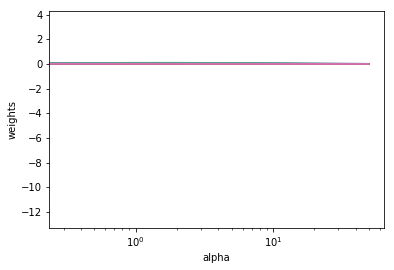

In [86]:
ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')

In [96]:
y = df_train['v_SalePrice']
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.5, 
                                                    random_state=1)
yL_train = np.log10(y_train)
yL_test = np.log10(y_test)

In [98]:
ridge3 = Ridge(alpha = 10**10, normalize = True)
# Fit a ridge regression on the training data
ridge3.fit(X_train, yL_train)
# Use the model to predict the data - note that we predict the Logged(SalePrice)
pred3L = ridge3.predict(X_test)
# Print coefficients of the logged model
print(pd.Series(ridge3.coef_, index = X.columns))
# calculate the predict price with the exponential
pred3 = np.power(pred3L, 10)
# calculate the RMSLE that is our KPI
print(rmsle(yL_test, pred3))

v_Alley_E                 -0.00000000
v_LotArea                  0.00000000
v_YearBuilt                0.00000000
v_TotalBsmtSF              0.00000000
v_GarageArea               0.00000000
v_LowQualFinSF            -0.00000000
v_GarageScore_TL3          0.00000000
v_WoodDeckSF               0.00000000
v_OverallGrade_D           0.00000000
v_GarageCars_TL3           0.00000000
v_OpenPorchSF              0.00000000
v_MoSold                   0.00000000
v_2ndFlrSF                 0.00000000
v_ExterQual_E              0.00000000
v_FullBath                 0.00000000
v_OverallQual_TLOG         0.00000000
v_BsmtUnfSF                0.00000000
v_GarageGrade_D            0.00000000
v_AllSF_TLOG               0.00000000
v_AllFlrsSF_TL2            0.00000000
v_AllSF_D                  0.00000000
v_SimplOverallQual_TSQ     0.00000000
v_AllFlrsSF_TSQ            0.00000000
v_MasVnrType_E             0.00000000
v_AllFlrsSF_TLOG           0.00000000
v_Electrical_E             0.00000000
v_SimplOvera

For some reason in my source the guy fit the regression with $\lambda = 4$

In [99]:
ridge2 = Ridge(alpha = 4, normalize = True)
ridge2.fit(X_train, yL_train)
pred2L = ridge2.predict(X_test)
pred2 = np.power(pred2L, 10)
print(pd.Series(ridge2.coef_, index = X.columns))
print(rmsle(y_test, pred2))

v_Alley_E                 -0.00067124
v_LotArea                  0.00000022
v_YearBuilt                0.00006295
v_TotalBsmtSF              0.00000701
v_GarageArea               0.00001055
v_LowQualFinSF             0.00000073
v_GarageScore_TL3          0.00036174
v_WoodDeckSF               0.00001520
v_OverallGrade_D           0.00039985
v_GarageCars_TL3           0.00543750
v_OpenPorchSF              0.00001566
v_MoSold                   0.00006440
v_2ndFlrSF                 0.00000128
v_ExterQual_E              0.00278065
v_FullBath                 0.00320444
v_OverallQual_TLOG         0.03543859
v_BsmtUnfSF               -0.00000080
v_GarageGrade_D            0.00025279
v_AllSF_TLOG               0.02530658
v_AllFlrsSF_TL2            0.00994834
v_AllSF_D                  0.00000415
v_SimplOverallQual_TSQ     0.01240126
v_AllFlrsSF_TSQ            0.00044379
v_MasVnrType_E             0.00098218
v_AllFlrsSF_TLOG           0.01991187
v_Electrical_E             0.00206996
v_SimplOvera

Now the guy tries to fit the Ridge Regression with $\lambda = 10^{10}$

In [100]:
ridge3 = Ridge(alpha = 10**10, normalize = True)
ridge3.fit(X_train, yL_train)
pred3L = ridge3.predict(X_test)
pred3 = np.power(pred3L, 10)
print(pd.Series(ridge3.coef_, index = X.columns))
print(rmsle(y_test, pred3))

v_Alley_E                 -0.00000000
v_LotArea                  0.00000000
v_YearBuilt                0.00000000
v_TotalBsmtSF              0.00000000
v_GarageArea               0.00000000
v_LowQualFinSF            -0.00000000
v_GarageScore_TL3          0.00000000
v_WoodDeckSF               0.00000000
v_OverallGrade_D           0.00000000
v_GarageCars_TL3           0.00000000
v_OpenPorchSF              0.00000000
v_MoSold                   0.00000000
v_2ndFlrSF                 0.00000000
v_ExterQual_E              0.00000000
v_FullBath                 0.00000000
v_OverallQual_TLOG         0.00000000
v_BsmtUnfSF                0.00000000
v_GarageGrade_D            0.00000000
v_AllSF_TLOG               0.00000000
v_AllFlrsSF_TL2            0.00000000
v_AllSF_D                  0.00000000
v_SimplOverallQual_TSQ     0.00000000
v_AllFlrsSF_TSQ            0.00000000
v_MasVnrType_E             0.00000000
v_AllFlrsSF_TLOG           0.00000000
v_Electrical_E             0.00000000
v_SimplOvera

Now the guy does what I would've expected at the beginning i.e use cross-validation to tune the value of $\alpha$. This has done using `RidgeCV()`. Anyway from the test we did realise that the best $\alpha$ should be greater than 4 but less than $10^{10}$

In [115]:
alphas = np.linspace(10E-30, 10**10, 1000)
ridgecv = RidgeCV(alphas = alphas, scoring = 'neg_mean_squared_error', 
                  normalize = True)
ridgecv.fit(X_train, yL_train)
ridgecv.alpha_

10010010.01001001

In [116]:
ridge4 = Ridge(alpha = ridgecv.alpha_, normalize = True)
ridge4.fit(X_train, yL_train)
pred4L = ridge4.predict(X_test)
pred4 = np.power(pred4L, 10)
rmsle(y_test, pred4)

4.543893733569923

Ridge Regression does not really work becuase before we had a RMSLE of 0.11 and on Kaggle the model has a RMSLE of 0.13 and the Ridge found a RMSLE of 4.5 that makes useless to use the technique.

In [36]:
import copy
new_vars2 = copy.deepcopy(new_vars)
new_vars2.remove('v_SalePrice')
new_vars2.remove('v_SalePrice_TLOG')
len(new_vars2)

197

In [37]:
df_test.shape

(1459, 197)

In [38]:
df_test.columns = new_vars2

In [69]:
y_Log_predicted = fitted.predict(df_test)
y_predicted = y_Log_predicted.apply(lambda x: 10 ** x)

In [40]:
df_test.head()

,v_Id,v_MSSubClass,v_MSZoning,v_LotFrontage,v_LotArea,v_Street,v_Alley,v_LotShape,v_LandContour,v_Utilities,...,v_TotalBath_TSQ,v_TotalBath_TLOG,v_KitchenQual_TL2,v_KitchenQual_TL3,v_KitchenQual_TSQ,v_KitchenQual_TLOG,v_GarageScore_TL2,v_GarageScore_TL3,v_GarageScore_TSQ,v_GarageScore_TLOG
0,1461,20,RH,80.000,11622,Pave,MISSING,Reg,Lvl,AllPub,...,1.000,0.301,0.699,0.954,1.414,0.477,6.681,10.021,46.797,3.341
1,1462,20,RL,81.000,14267,Pave,MISSING,IR1,Lvl,AllPub,...,1.225,0.398,1.000,1.447,1.732,0.602,5.943,8.914,30.594,2.972
2,1463,60,RL,74.000,13830,Pave,MISSING,IR1,Lvl,AllPub,...,1.581,0.544,0.699,0.954,1.414,0.477,6.320,9.481,38.026,3.160
3,1464,60,RL,78.000,9978,Pave,MISSING,IR1,Lvl,AllPub,...,1.581,0.544,1.000,1.447,1.732,0.602,6.298,9.448,37.550,3.150
4,1465,120,RL,43.000,5005,Pave,MISSING,IR1,HLS,AllPub,...,1.414,0.477,1.000,1.447,1.732,0.602,6.363,9.544,38.962,3.182


In [70]:
y_predicted.index = df_test['v_Id']
y_predicted.columns = ['Id', 'SalePrice']
y_predicted.head()

v_Id
1461   110404.00554979
1462   147671.28424825
1463   170918.59887292
1464   198045.31027077
1465   192627.23318179
dtype: float64

In [42]:
import datetime
prefix = datetime.datetime.now().strftime('%Y%m%d %H%M')
y_predicted.to_csv('../15. Out/' + prefix + ' Submission.csv')
print('15. Out/' + prefix + ' Submission.csv WRITTEN')

15. Out/20190502 0949 Submission.csv WRITTEN
